<a href="https://colab.research.google.com/github/034adarsh/Stock-Price-Prediction-Using-LSTM/blob/main/LSTM_Improved_model(diff_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the required libraries

---



In [3]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
#import yfinance as yf
import numpy as np
import tensorflow as tf

# Dataset: change from Yahoo stock data to BTC 1-min data

---



In [41]:
df = pd.read_csv("../data/btcusd_1-min_data.csv")

In [57]:
df.tail()


,Timestamp,Open,High,Low,Close,Volume
6707276,2024-11-01 23:57:00,69511.0,69511.0,69491.0,69491.0,0.101946
6707277,2024-11-01 23:58:00,69490.0,69490.0,69490.0,69490.0,0.006393
6707278,2024-11-01 23:59:00,69491.0,69491.0,69490.0,69490.0,0.074621
6707279,2024-11-02 00:00:00,69468.0,69474.0,69468.0,69474.0,0.007074
6707280,NaT,57854.0,57864.0,57835.0,57835.0,1.353466


In [45]:
len(df)

6707281

In [47]:
df['Timestamp'][0]

1325412060.0

In [49]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', errors='coerce')


In [51]:
df['Timestamp'][0]

Timestamp('2012-01-01 10:01:00')

In [53]:
null_count = df['Timestamp'].isna().sum()
print(f"Number of null timestamps: {null_count}")


Number of null timestamps: 1


In [ ]:
data.head()

In [55]:
if null_count > 0:
    print("Rows with null Timestamp:")
    print(df[df['Timestamp'].isna()])

Rows with null Timestamp:
        Timestamp     Open     High      Low    Close    Volume
6707280       NaT  57854.0  57864.0  57835.0  57835.0  1.353466


In [73]:
# Remove rows with null timestamp
df = df[df['Timestamp'].notna()]
df = df.set_index('Timestamp')

In [75]:
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [77]:
# 3. Sort index just in case
df = df.sort_index()

In [81]:
# 4. Data integrity checks

# (a) Check for duplicates
dup_count = df.index.duplicated().sum()
print(f"Number of duplicate timestamps: {dup_count}")

if dup_count > 0:
    print("Duplicate timestamp rows:")
    print(df[df.index.duplicated(keep=False)])

# (b) Check if index is strictly increasing
is_monotonic = df.index.is_monotonic_increasing
print(f"Timestamps strictly increasing: {is_monotonic}")

# (c) Optional: check for gaps in the 1-min frequency
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="min")
missing_timestamps = expected_range.difference(df.index)

print(f"Number of missing 1-min timestamps: {len(missing_timestamps)}")
if len(missing_timestamps) > 0:
    print("Example missing timestamps:", missing_timestamps[:10])  # show first 10

Number of duplicate timestamps: 0
Timestamps strictly increasing: True
Number of missing 1-min timestamps: 44280
Example missing timestamps: DatetimeIndex(['2012-11-04 06:00:00', '2012-11-04 06:01:00',
               '2012-11-04 06:02:00', '2012-11-04 06:03:00',
               '2012-11-04 06:04:00', '2012-11-04 06:05:00',
               '2012-11-04 06:06:00', '2012-11-04 06:07:00',
               '2012-11-04 06:08:00', '2012-11-04 06:09:00'],
              dtype='datetime64[ns]', freq=None)


In [83]:
# Reindex to full 1-min frequency
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="min")
df = df.reindex(full_index)

# Forward fill price columns, keep Volume as 0 if missing
price_cols = ['Open', 'High', 'Low', 'Close']
df[price_cols] = df[price_cols].ffill()

# Fill missing volumes with 0 (no trade happened)
df['Volume'] = df['Volume'].fillna(0)

# Rename index back to Timestamp if you want
df.index.name = 'Timestamp'

df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [85]:
len(df)

6751560

Visualizing Closing Price

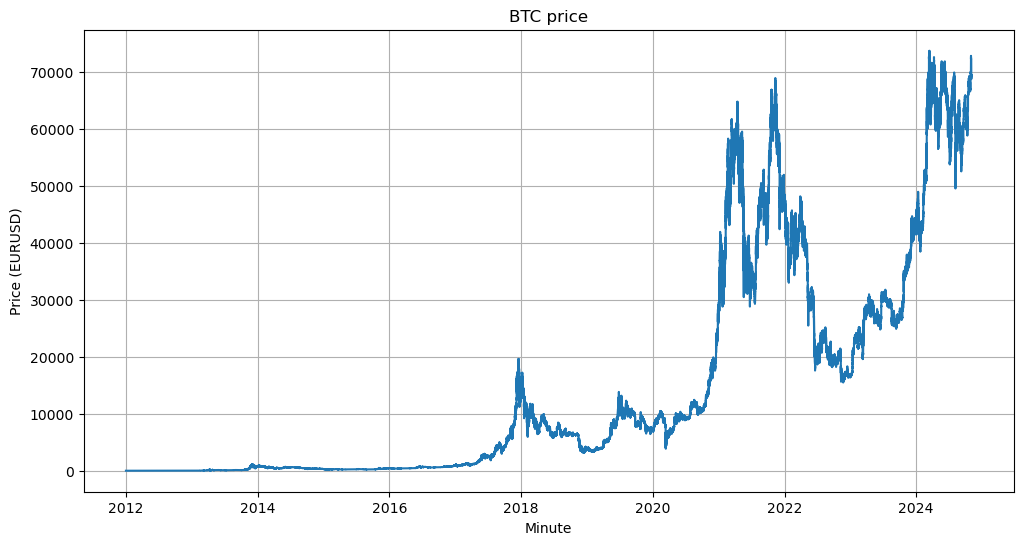

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("BTC price")
plt.xlabel("Minute")
plt.ylabel("Price (EURUSD)")
plt.grid(True)
plt.show()

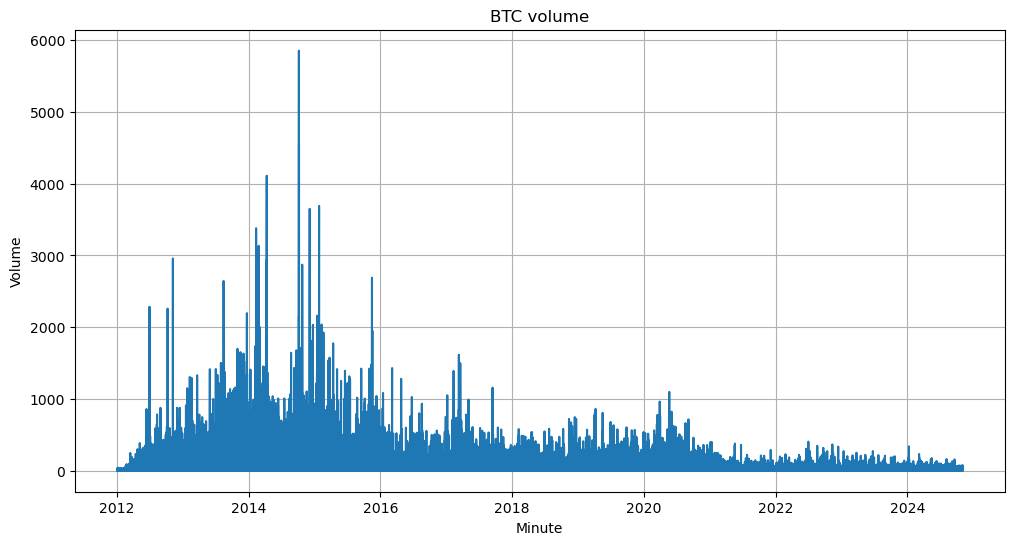

In [94]:
# visualize volume
plt.figure(figsize=(12, 6))
plt.plot(df['Volume'])
plt.title("BTC volume")
plt.xlabel("Minute")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

In [96]:
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2024-11-01 23:56:00,69512.00,69512.00,69512.00,69512.00,0.000000
2024-11-01 23:57:00,69511.00,69511.00,69491.00,69491.00,0.101946
2024-11-01 23:58:00,69490.00,69490.00,69490.00,69490.00,0.006393


In [101]:
df.index[0]

Timestamp('2012-01-01 10:01:00')

In [99]:
df.index[0].normalize()

Timestamp('2012-01-01 00:00:00')

# Dataset: transform to daily 

---

In [105]:
import pandas as pd

# Assume df has Timestamp index at 1-min freq

# 1. Resample to daily OHLC and sum volume
daily = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# 2. Drop days where all values are NaN (e.g., no trading at all)
daily = daily.dropna(how='all')

# 3. Identify fractional first/last days
first_day = df.index[0].normalize()
last_day = df.index[-1].normalize()

# Drop first day if it starts after midnight
if df.index[0] > first_day:
    daily = daily.drop(first_day, errors="ignore")

# Drop last day if it ends before midnight
if df.index[-1] < last_day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1):
    daily = daily.drop(last_day, errors="ignore")

print(f"Final daily dataset has {len(daily)} rows after dropping fractional days.")

Final daily dataset has 4688 rows after dropping fractional days.


In [107]:
daily.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742
2012-01-06,6.42,6.90,6.40,6.40,55.855834


In [109]:
df = daily

In [115]:
len(df)

4688

# Plotting moving averages of 100 day

---



In [111]:
ma100 = df.Close.rolling(100).mean()
ma100

Timestamp
2012-01-02         NaN
2012-01-03         NaN
2012-01-04         NaN
2012-01-05         NaN
2012-01-06         NaN
                ...   
2024-10-28    62261.42
2024-10-29    62286.38
2024-10-30    62327.36
2024-10-31    62395.35
2024-11-01    62434.14
Freq: D, Name: Close, Length: 4688, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

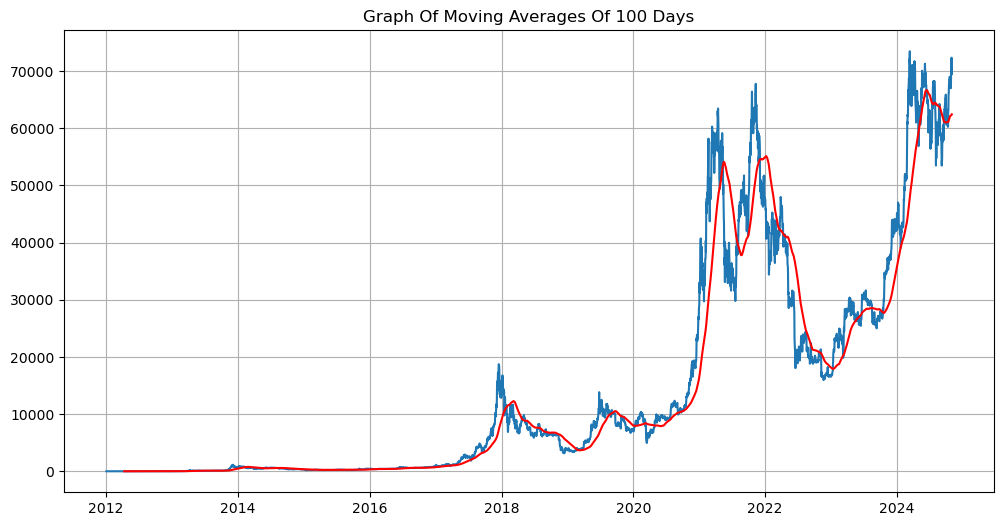

In [113]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days')

# Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

---



In [117]:
ma200 = df.Close.rolling(200).mean()
ma200

Timestamp
2012-01-02          NaN
2012-01-03          NaN
2012-01-04          NaN
2012-01-05          NaN
2012-01-06          NaN
                ...    
2024-10-28    63232.665
2024-10-29    63248.165
2024-10-30    63285.390
2024-10-31    63326.090
2024-11-01    63356.795
Freq: D, Name: Close, Length: 4688, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

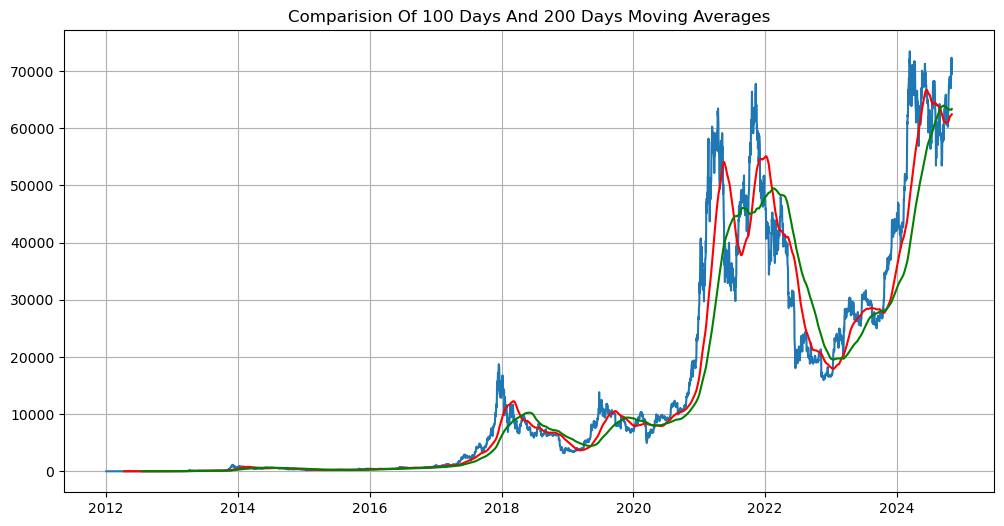

In [119]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

In [121]:
df.shape

(4688, 5)

# Spliting the dataset into training (70%) and testing (30%) set

In [143]:
# Splitting data into training and testing

train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

(3281, 5)
(1407, 5)


In [145]:
train.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742
2012-01-06,6.42,6.90,6.40,6.40,55.855834


In [164]:
test.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2020-12-26,24356.63,25985.93,24194.12,25620.57,5891.021658
2020-12-27,25631.37,28377.94,25572.91,27009.58,13373.305793
2020-12-28,26998.78,27473.49,25770.00,26990.99,9034.221715
2020-12-29,26982.60,27162.17,25831.85,26577.94,9026.194760
2020-12-30,26577.94,28599.99,26521.17,28525.26,11065.005263


# Using MinMax scaler for normalization of the dataset

---



In [252]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [254]:
train_close = train.iloc[:, 3:4].values
test_close = test.iloc[:, 3:4].values

In [256]:
train.iloc[:, 3:4]

,Close
Timestamp,
2012-01-02,5.00
2012-01-03,5.29
2012-01-04,5.57
2012-01-05,6.42
2012-01-06,6.40
...,...
2020-12-21,22818.47
2020-12-22,23436.63
2020-12-23,23615.26


In [258]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[2.54738653e-05],
       [3.73890603e-05],
       [4.88933865e-05],
       ...,
       [9.70097380e-01],
       [9.58016194e-01],
       [1.00000000e+00]])

In [260]:
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [262]:
x_train.shape

(3181, 100, 1)

# ML Model (LSTM)

---



In [173]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [175]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

/opt/anaconda3/envs/algo_trading/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [177]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

---



In [180]:
import tensorflow as tf
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train,epochs = 100)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 0.0164 - mean_absolute_error: 0.0776
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0030 - mean_absolute_error: 0.0309
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0032 - mean_absolute_error: 0.0319
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0025 - mean_absolute_error: 0.0296
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0023 - mean_absolute_error: 0.0273
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0021 - mean_absolute_error: 0.0274
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0022 - mean_absolute_error: 0.0265
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.0021 - mean_absolute_error: 0.0267
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.0023 - mean_absolute_error: 0.0289
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.0021 - mean_absolute_err

In [182]:
model.save('keras_model_btc_daily.h5')

In [184]:
test_close.shape

(1407, 1)

In [186]:
past_100_days = pd.DataFrame(train_close[-100:])

In [188]:
test_df = pd.DataFrame(test_close)

**Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.**

---


In [205]:
pd.concat([past_100_days, test_df])

,0
0,10921.98
1,10868.27
2,11054.52
3,10869.15
4,10495.00
...,...
1402,69918.00
1403,69956.00
1404,72331.00
1405,72346.00


In [207]:
final_df = pd.concat([past_100_days, test_df], ignore_index = True)

In [209]:
final_df.head()

,0
0,10921.98
1,10868.27
2,11054.52
3,10869.15
4,10495.00


In [277]:
# Wrong! Should NOT fit the scaler by input data
#input_data = scaler.fit_transform(final_df)

# correct version:
input_data = scaler.transform(final_df)
input_data

array([[0.44857011],
       [0.44636334],
       [0.45401577],
       ...,
       [2.97167512],
       [2.97229142],
       [2.85494729]])

In [279]:
input_data.shape

(1507, 1)

# Testing the model

---



In [282]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [284]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1407, 100, 1)
(1407,)


# Making prediction and plotting the graph of predicted vs actual values

---



In [287]:
# Making predictions

y_pred = model.predict(x_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [289]:
y_pred.shape

(1407, 1)

In [291]:
y_test

array([1.05248931, 1.1095594 , 1.10879559, ..., 2.97167512, 2.97229142,
       2.85494729])

In [293]:
y_pred

array([[0.88614905],
       [0.91431075],
       [0.9474212 ],
       ...,
       [1.7659113 ],
       [1.2743025 ],
       [1.8155321 ]], dtype=float32)

In [295]:
scaler.scale_

array([4.10868794e-05])

In [297]:
scale_factor = 1/0.00041967
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

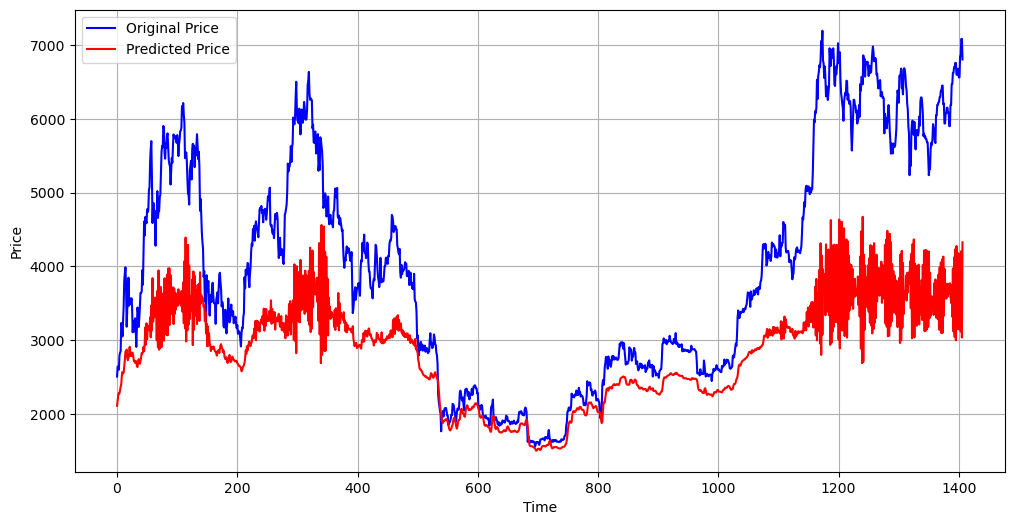

In [299]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation

Calculation of mean absolute error

In [312]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 27.96%


Calculation of R2 score

In [315]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.1075875650457856


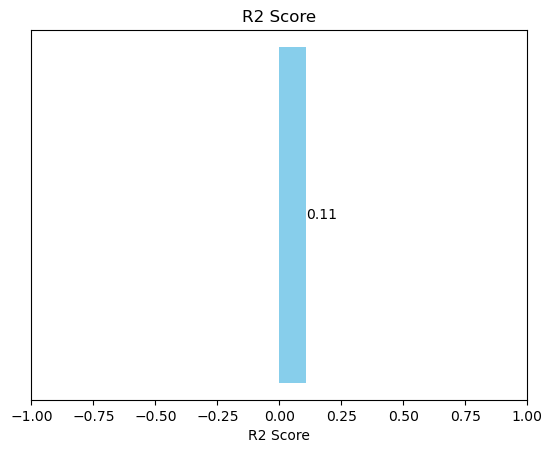

In [317]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

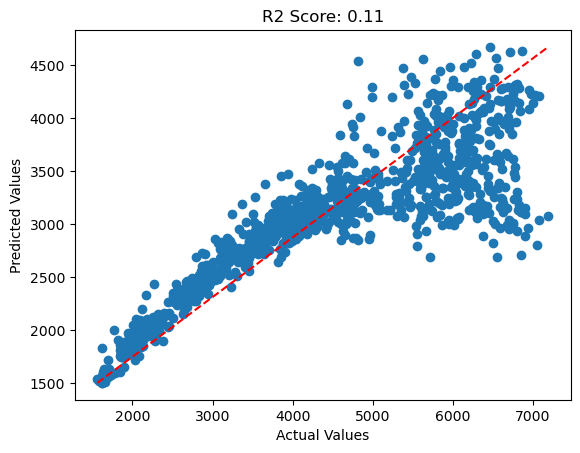

In [319]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()